In [1]:
#Load the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils._mocking import CheckingClassifier

from sklearn.linear_model import RidgeClassifierCV
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import NuSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

#load the helping functions
from pipeline_functionsres import replace_inf_with_nans, standadize_cols_per_subject, replace_with_nan
from pipeline_functionsres import impute_per_subject,replace_with_ceiling, get_feature_matrix, get_feature_matrix_with_labels
from pipeline_functionsres import get_stats_for_elbow_curve, get_optimal_features_and_methods

In [2]:
#Load the data and drop the left pupil
subjects_with_conditions_df = pd.read_csv('../subjects_with_conditions_df.csv').drop('Unnamed: 0', axis = 1).drop('left_pupil', axis = 1)

In [3]:
#Data curation- remove subject 1009 since it has 60% broken trials
subjects_with_conditions_df = subjects_with_conditions_df.loc[subjects_with_conditions_df['subject']!= 1009]

In [4]:
#Data curation- use the ceiling value for RT and gazes to limit high values

ceiling_df = replace_with_ceiling(subjects_with_conditions_df)

In [5]:
ceiling_df.head()

subject  sample    time  trial currentobject   rt  right_pupil  \
0      845       1  342413      1         Timer  284          NaN   
1      845       2  342421      1         Timer  284          NaN   
2      845       3  342430      1         Timer  284          NaN   
3      845       4  342439      1         Timer  284          NaN   
4      845       5  342446      1         Timer  284          NaN   

   right_gaze_x  right_gaze_y  left_gaze_x  left_gaze_y  goal  feedback  \
0           NaN           NaN          NaN          NaN     2         0   
1           NaN           NaN          NaN          NaN     2         0   
2           NaN           NaN          NaN          NaN     2         0   
3           NaN           NaN          NaN          NaN     2         0   
4           NaN           NaN          NaN          NaN     2         0   

   reward  bi_goal  bi_feedback  bi_reward  tir_goal  tir_reward  label_7  
0       0      1.0          NaN        NaN       2.0         NaN        3  
1       0      1.0          NaN        NaN       2.0         NaN        3  
2       0      1.0          NaN        NaN       2.0         NaN        3  
3       0      1.0          NaN        NaN       2.0         NaN        3  
4       0      1.0          NaN        NaN       2.0         NaN        3

In [6]:
#ceiling_df

In [7]:
#Feature engineering - Adding the Deviation feature to the df

ceiling_df['RDEV'] = np.sqrt((ceiling_df['right_gaze_x'] - .5)**2 + (ceiling_df['right_gaze_y'] - .5)**2) 
ceiling_df['LDEV'] = np.sqrt((ceiling_df['left_gaze_x'] - .5)**2 + (ceiling_df['left_gaze_y'] - .5)**2) 

In [8]:
#Feature engineering- Taking means and variances

FE_df =  ceiling_df.groupby(['subject', 'trial']).agg({'right_pupil': ['mean', 'var'], 'LDEV': ['mean', 'var'], 
                                                       'RDEV': ['mean', 'var'],'rt': 'mean' }).reset_index()

In [9]:
# Data imputation

imputed_df = impute_per_subject(FE_df)

In [10]:
#Data standardization. This is done per subject

standardized_df = standadize_cols_per_subject(imputed_df)


/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/Classification/pipeline_functionsres.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df[columns[j]] = scaler.fit_transform(subject_df[columns[j]].values.reshape(-1,1))
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/Classification/pipeline_functionsres.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [11]:
standardized_df

subject  trial right_pupil                LDEV                RDEV  \
                          mean       var      mean       var      mean   
0     845.0    1.0    0.718531  0.363729  0.783327  0.154816  0.888538   
1     845.0    2.0    0.655245  0.133423  0.480928  0.079381  0.529261   
2     845.0    3.0    0.327336  0.076988  0.356999  0.005302  0.493781   
3     845.0    4.0    0.443157  0.044487  0.331960  0.010487  0.452536   
4     845.0    5.0    0.336879  0.166392  0.432272  0.035180  0.817592   
..      ...    ...         ...       ...       ...       ...       ...   
135  1246.0  136.0    0.324065  0.026111  0.036666  0.004575  0.087436   
136  1246.0  137.0    0.248118  0.051316  0.078618  0.002814  0.067236   
137  1246.0  138.0    0.548926  0.149668  0.027677  0.006607  0.086613   
138  1246.0  139.0    0.545797  0.271756  0.119380  0.010077  0.068995   
139  1246.0  140.0    0.747790  0.121003  0.070851  0.005885  0.055885   

                     rt  
          var      mean  
0    0.132537  0.125000  
1    0.101091  0.293651  
2    0.012354  0.228175  
3    0.039653  0.156746  
4    0.088238  0.172619  
..        ...       ...  
135  0.001494  0.229572  
136  0.001237  0.107004  
137  0.002638  0.023346  
138  0.004863  0.198444  
139  0.002028  0.073930  

[48860 rows x 9 columns]

In [12]:
#Get the feature matrix

Feature_matrix_df = get_feature_matrix(standardized_df)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [13]:
Feature_matrix_df

1         2         3         4         5         6         7    \
845.0   0.718531  0.655245  0.327336  0.443157  0.336879  0.213414  0.216704   
846.0   0.890184  0.876509  0.525048  0.703541  0.541176  0.513490  0.533830   
847.0   0.357387  0.297813  0.802681  0.543541  0.673288  0.435294  0.500908   
848.0   0.423918  0.421592  0.352956  0.318847  0.323888  0.300182  0.366398   
849.0   0.571958  0.408893  0.395655  0.520751  0.437383  0.340203  0.337662   
...          ...       ...       ...       ...       ...       ...       ...   
1242.0  0.256731  0.298219  0.309233  0.290068  0.327924  0.267295  0.238285   
1243.0  0.741593  0.562594  0.365681  0.489031  0.553534  0.445926  0.513268   
1244.0  0.775790  0.694807  0.681949  0.565425  0.375596  0.724900  0.578049   
1245.0  1.000000  0.649888  0.644179  0.633921  0.532530  0.728030  0.700959   
1246.0  0.525967  0.351865  0.354557  0.271316  0.479317  0.226760  0.219225   

             8         9         10   ...       971       972       973  \
845.0   0.673229  0.465331  0.445478  ...  0.297619  0.297619  0.297619   
846.0   0.441735  0.787322  0.838608  ...  0.284960  0.092348  0.058047   
847.0   0.981565  0.014090  0.366399  ...  0.517778  0.200000  0.322222   
848.0   0.274508  0.325481  0.398756  ...  0.666667  0.708551  0.638743   
849.0   0.331084  0.292554  0.279469  ...  0.122936  0.188991  0.188991   
...          ...       ...       ...  ...       ...       ...       ...   
1242.0  0.399401  0.221854  0.222658  ...  0.278523  0.147651  0.093960   
1243.0  0.476346  0.474716  0.468714  ...  0.217097  0.319509  0.077444   
1244.0  0.341460  0.528451  0.548866  ...  0.269231  0.107692  0.084615   
1245.0  0.707397  0.745746  0.841759  ...  0.112339  0.364641  0.204420   
1246.0  0.326546  0.261975  0.276396  ...  0.112840  0.056420  0.087549   

             974       975       976       977       978       979       980  
845.0   0.309524  0.228175  0.359127  0.202381  0.257937  0.265873  0.634921  
846.0   0.430079  0.211082  0.385224  0.258575  0.147757  0.142480  0.121372  
847.0   0.340000  0.662222  0.504444  0.262222  0.324444  0.106667  0.384444  
848.0   0.638743  0.638743  0.530541  0.703316  0.493892  0.757417  0.530541  
849.0   0.152294  0.354128  0.062385  0.104587  0.218349  0.121101  0.163303  
...          ...       ...       ...       ...       ...       ...       ...  
1242.0  0.295302  0.218121  0.151007  0.231544  0.345638  0.201342  0.167785  
1243.0  0.077444  0.077444  0.615320  0.615320  0.615320  0.615320  0.615320  
1244.0  0.143590  0.130769  0.097436  0.074359  0.202564  0.046154  0.205128  
1245.0  0.736648  0.252302  0.116022  0.406998  0.471455  0.406998  0.093923  
1246.0  0.085603  0.097276  0.229572  0.107004  0.023346  0.198444  0.073930  

[349 rows x 980 columns]

In [14]:
#Group the columns by 20
new_feature_matrix_df = pd.DataFrame()
for i in range(49):
    col = Feature_matrix_df.loc[: , i+1:i+20]
    new_feature_matrix_df[i+1] = col.mean(axis=1)

In [15]:
new_feature_matrix_df

1         2         3         4         5         6         7   \
845.0   0.467544  0.460992  0.459456  0.470894  0.469204  0.474007  0.481309   
846.0   0.642559  0.632204  0.612573  0.624402  0.619589  0.622016  0.638003   
847.0   0.475437  0.476133  0.484378  0.480069  0.493259  0.482388  0.481989   
848.0   0.305698  0.300312  0.295524  0.291132  0.289393  0.283201  0.277294   
849.0   0.386700  0.370326  0.361046  0.354672  0.339177  0.329589  0.332883   
...          ...       ...       ...       ...       ...       ...       ...   
1242.0  0.319937  0.321829  0.318305  0.317987  0.315856  0.317810  0.314696   
1243.0  0.420960  0.409516  0.389575  0.386464  0.388124  0.385953  0.378943   
1244.0  0.558231  0.536716  0.525316  0.537434  0.528042  0.529808  0.543563   
1245.0  0.628063  0.605397  0.598655  0.589174  0.594574  0.599286  0.584197   
1246.0  0.299510  0.283737  0.274945  0.271757  0.280507  0.277711  0.284623   

              8         9         10  ...        40        41        42  \
845.0   0.506901  0.504607  0.505330  ...  0.467075  0.457873  0.463690   
846.0   0.633941  0.661629  0.645237  ...  0.364549  0.357122  0.349888   
847.0   0.471676  0.453908  0.468066  ...  0.309390  0.316112  0.279886   
848.0   0.270047  0.268614  0.263961  ...  0.128973  0.132667  0.132589   
849.0   0.341410  0.341579  0.345631  ...  0.312395  0.314392  0.308711   
...          ...       ...       ...  ...       ...       ...       ...   
1242.0  0.316150  0.307564  0.313354  ...  0.242860  0.231575  0.234437   
1243.0  0.360918  0.358572  0.361511  ...  0.434796  0.454907  0.437614   
1244.0  0.558920  0.551340  0.563875  ...  0.291759  0.301343  0.312365   
1245.0  0.581680  0.569532  0.574658  ...  0.608652  0.595070  0.590807   
1246.0  0.293980  0.289976  0.299834  ...  0.296712  0.302817  0.303160   

              43        44        45        46        47        48        49  
845.0   0.468645  0.486607  0.481443  0.477113  0.467069  0.461619  0.437271  
846.0   0.336322  0.325821  0.360592  0.353653  0.352035  0.340971  0.341402  
847.0   0.271911  0.278039  0.273986  0.266830  0.266770  0.281037  0.285294  
848.0   0.138367  0.138530  0.138704  0.135083  0.128468  0.121003  0.121246  
849.0   0.308319  0.300045  0.293661  0.279161  0.266411  0.254603  0.266672  
...          ...       ...       ...       ...       ...       ...       ...  
1242.0  0.233150  0.235285  0.232483  0.227404  0.232050  0.229456  0.231064  
1243.0  0.420392  0.423518  0.411227  0.406830  0.402380  0.395928  0.385727  
1244.0  0.305134  0.308120  0.320643  0.320843  0.321314  0.318328  0.327721  
1245.0  0.579948  0.583026  0.564723  0.545794  0.545494  0.564681  0.593589  
1246.0  0.293807  0.318378  0.321440  0.323329  0.325575  0.336782  0.349519  

[349 rows x 49 columns]

In [16]:
Feature_matrix_with_labels =  get_feature_matrix_with_labels(subjects_with_conditions_df, new_feature_matrix_df)

In [17]:
def get_aic_bic_coefs_and_alphas(df):
    from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
    import time
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    #feature_df = df.iloc[:, 0:196]
    feature_df = df.drop(label_list, axis =1)
    aic_coefficients =  []
    bic_coefficients = []
    aic_alphas = []
    bic_alphas = []
    for i in range(6):
        label_series = df[label_list[i]]
        problem_df1 = pd.concat([feature_df, label_series], axis =1) 
        problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
        cols = len(feature_df.columns) #this has the right dimension
        X = problem_df2.iloc[:, 0:cols]
        X= X.astype('float')
        Y = problem_df2[label_list[i]]
        Y= Y.astype('int')

        model_bic = LassoLarsIC(criterion='bic')
        t1 = time.time()
        bic_model = model_bic.fit(X, Y)
        t_bic = time.time() - t1
        alpha_bic = model_bic.alpha_

        bic_coefficients.append(bic_model.coef_.tolist())
        bic_alphas.append(alpha_bic)

        model_aic = LassoLarsIC(criterion='aic')
        aic_model = model_aic.fit(X, Y)
        alpha_aic = model_aic.alpha_

        aic_coefficients.append(aic_model.coef_.tolist())
        aic_alphas.append(alpha_aic)
        
    return aic_coefficients, bic_coefficients , aic_alphas, bic_alphas
    

In [18]:
aic_coefficients, bic_coefficients , aic_alphas, bic_alphas = get_aic_bic_coefs_and_alphas(Feature_matrix_with_labels)

In [19]:
#Getting the optimal alpha and l_1 ratio for elasticnetc using elasticnetcv

def get_alpha_and_l1_for_elasticnet(df):
    from sklearn.linear_model import ElasticNetCV
    
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    feature_df = df.drop(label_list, axis = 1)
    elas_alphas = []
    elas_l1 = []
    for i in range(6):
        label_series = df[label_list[i]]
        problem_df1 = pd.concat([feature_df, label_series], axis =1) 
        problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
        X = problem_df2.drop(label_list[i], axis = 1)
        X= X.astype('float')
        Y = problem_df2[label_list[i]]
        Y= Y.astype('int')

        model = ElasticNetCV(l1_ratio= [.1,.5,.7,.9,.95, .99, 1], n_alphas= 100, cv= 5, random_state=1000)
        model.fit(X, Y)
        elas_alphas.append(model.alpha_)
        elas_l1.append(model.l1_ratio_)
        
    return elas_alphas, elas_l1

In [20]:
elas_alphas, elas_l1 = get_alpha_and_l1_for_elasticnet(Feature_matrix_with_labels)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005465290589757643, tolerance: 0.003328467153284671
  model = cd_fast.enet_coordinate_descent_gram(
/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007134163998493648, tolerance: 0.003328467153284671
  model = cd_fast.enet_coordinate_descent_gram(
/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010224280837753952, tolerance: 0.003328467153284671
  model = cd_

In [21]:
#trying the elasticnet aplhas with elasticnet
def get_elasticnet_features(df,elas_alphas, elas_l1):

    from sklearn.linear_model import ElasticNet
    label_list =  ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    feature_df = df.drop(label_list, axis = 1)
    elasti_feature_list = [] 
    elasti_no_of_features = []
    
    for j in range(1):
        for i in range(6):
            label_series = df[label_list[i]]
            problem_df1 = pd.concat([feature_df, label_series], axis =1) 
            problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
            X = problem_df2.drop(label_list[i], axis = 1)
            X= X.astype('float')
            Y = problem_df2[label_list[i]]
            Y= Y.astype('int')

            model = ElasticNet(alpha = elas_alphas[i], l1_ratio= 0, random_state=1000)
            model.fit(X, Y)
            coefs = model.coef_.tolist()


            no_of_features = len([x for x in coefs if x != 0]) #counts the number of non zero coefficients
            sorted_score_list = np.argsort(-np.array(coefs), kind='mergesort') #this gives the indices of the highest element to the lowest element
            feature_indices = sorted_score_list[0:no_of_features ]
            elasti_feature_list.append([x+1 for x in feature_indices]) #because indices are one less the actual feature 
            elasti_no_of_features.append(no_of_features)
            
    return elasti_feature_list, elasti_no_of_features

In [22]:
elasti_feature_list, elasti_no_of_features = get_elasticnet_features(Feature_matrix_with_labels, elas_alphas, elas_l1)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.34572482549096, tolerance: 0.004111627906976744
  model = cd_fast.enet_coordinate_descent(
/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.968616283006654, tolerance: 0.0022666666666666664
  model = cd_fast.enet_coordinate_descent(
/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.61493327456541, tolerance: 0.0035748251748251793
  model = cd_fast.enet_coordin

In [23]:
#Getting the lassolarsIC feature list
def get_features_and_no_of_features(aic_coefficients, bic_coefficients):
    #Normalize the list
    def normalize(list1):
        if sum(list1)== 0:
            new_list = list1
        else:
            norm = np.linalg.norm(list1)
            new_list = [abs(x/norm) for x in list1]
        return new_list
    
    #Normalize the coeficients
    normlzd_aic_coef = []
    normlzd_bic_coef = []
    for i in range(6):
        normlzd_aic_coef.append(normalize(list(map(abs,aic_coefficients[i]))))
        normlzd_bic_coef.append(normalize(list(map(abs,bic_coefficients[i]))))
        
    #get the features   
    feature_list = []
    no_of_features_list = []
    for i in range(6):
    
        score_list = [(g + h) for g, h in zip(normlzd_aic_coef[i], normlzd_bic_coef[i])] #giving a score to each feature
        no_of_features = len([x for x in score_list if x != 0]) #counts the number of non zero coefficients
        sorted_score_list = np.argsort(-np.array(score_list), kind='mergesort') #this gives the indices of the highest element to the lowest element
        feature_indices = sorted_score_list[0:no_of_features ]
        feature_list.append([x+1 for x in feature_indices]) #because indices are one less the actual feature 
        no_of_features_list.append(no_of_features)

    return feature_list, no_of_features_list

In [24]:
#get the number of features and the features using aic, bic
feature_list, no_of_features_list = get_features_and_no_of_features(aic_coefficients, bic_coefficients) 

In [25]:
no_of_features_list

[9, 3, 3, 0, 0, 5]

In [25]:
no_of_features_list

[4, 3, 0, 2, 11, 4]

In [26]:
#Gluing the Lasso and ELasticNet features to get the best number of features and methods
def get_lasso_elast_features(feature_list, elasti_feature_list):
    def get_clean_set(seq):
            seen = set()
            seen_add = seen.add
            return [x for x in seq if not (x in seen or seen_add(x))]

    lasso_elasti_features = []
    for i in range(6):
        c = feature_list[i]
        b = elasti_feature_list[i][0:2] 
        c.extend(b) #glue the first 25 features of elasti to the back of lasso. Now the feature_list is changed. This has repititions
        lasso_elasti_features.append(get_clean_set(c))
        
    return lasso_elasti_features

In [27]:
lasso_elasti_features = get_lasso_elast_features(feature_list, elasti_feature_list) #extended feature list

In [28]:
lasso_elasti_features

[[3, 2, 31, 25, 27, 29, 15, 40, 49, 32],
 [4, 33, 40, 24],
 [15, 18, 45, 12],
 [32, 31],
 [9, 12],
 [9, 20, 6, 1, 48]]

In [28]:
# Since there are no features for C3, we will use C5 features for C3
#lasso_elasti_features[2] = lasso_elasti_features[4]

In [29]:
def get_stats_for_elbow_curve_new(df, feature_list):

    from sklearn.model_selection import train_test_split
    balanced_accuracy_df_list = [] #This list will have the balanced accuracy df's for the 6 problems
    from Lazy_predict_version_Nethali_new1 import Classification
    #%load_ext line_profiler
    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7'] 
    accuracy_dict_list = []
    aic_dict_list = []
    
    for k in range(1):
        for c in range(6):
            features_for_problem = feature_list[c]
            accuracy_dict_for_problem = {}
            aic_dict_for_problem = {}
            label_series = df[label_list[c]] 
            for j in range(len(features_for_problem)):
                feature_index_list = [x-1 for x in features_for_problem[0:j+1]] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
                balanced_accuracy_for_problem_df_list1 = [] #this is specific to a given j
                aic_for_problem_df_list2 = []
                problem_df = df.iloc[:,feature_index_list] #this needs to be changed to pick one feature at a time [0: len(feat)], the new feature matrix 7/5
                
                #This is for a particular j no of features
                
                for i in range(5): #This is for manual cv
                    random_state = [42, 35, 68, 92, 70] 
                    #random_state = [42, 35, 68, 92, 80] 
                   
                    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
                    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
                    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
                    X= X.astype('float')
                    Y = problem_df2[label_list[c]]
                    Y= Y.astype('int')
                    
                    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
                    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
                    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
                    balanced_accuracy_for_problem_df_list1.append(models.drop(['AIC', 'ROC AUC', 'F1 Score', 'Time Taken', 'Balanced Accuracy','Misclassifications'], axis = 1).rename(columns={"Accuracy":str(i)}))
                    aic_for_problem_df_list2.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken', 'Balanced Accuracy','Misclassifications'], axis = 1).rename(columns={"AIC":str(i)}))
                #get the resulting concat df
                result_df1 = pd.concat(balanced_accuracy_for_problem_df_list1, axis=1)
                result_df2 = pd.concat(aic_for_problem_df_list2, axis=1)
                #get the lowest median for df2 and highest accuracy for df1
                accuracy_dict_for_problem[str(j+1)+'features'] = (result_df1.mean(axis= 1).max(), 
                                                                result_df1.mean(axis= 1).idxmax())
                aic_dict_for_problem[str(j+1)+'features'] = (result_df2.mean(axis= 1).min(), 
                                                                result_df2.mean(axis= 1).idxmin())
            accuracy_dict_list.append(accuracy_dict_for_problem)
            aic_dict_list.append(aic_dict_for_problem)
    return accuracy_dict_list , aic_dict_list 

In [30]:
accuracy_dict_list,aic_dict_list =  get_stats_for_elbow_curve_new(Feature_matrix_with_labels, lasso_elasti_features) #Need to use the extended features here

 76%|███████▌  | 22/29 [00:00<00:00, 59.07it/s]

[11:24:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.76it/s]

[11:24:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.17it/s]

[11:24:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.04it/s]

[11:24:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.06it/s]

[11:24:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.35it/s]

[11:24:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.94it/s]

[11:24:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.74it/s]

[11:24:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.37it/s]

[11:24:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.68it/s]

[11:24:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.75it/s]

[11:24:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.62it/s]

[11:24:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.74it/s]

[11:24:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.77it/s]

[11:24:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.45it/s]

[11:24:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 36.62it/s]

[11:24:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.14it/s]

[11:24:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.39it/s]

[11:24:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 33.71it/s]

[11:24:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.42it/s]

[11:24:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.82it/s]

[11:24:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.14it/s]

[11:24:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.42it/s]

[11:24:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.91it/s]

[11:24:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.83it/s]

[11:24:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.63it/s]

[11:24:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 22.94it/s]

[11:24:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.86it/s]

[11:24:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 39.45it/s]

[11:24:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.40it/s]

[11:24:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 24.52it/s]

[11:24:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 23.00it/s]

[11:24:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 57.17it/s]

[11:25:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.76it/s]

[11:25:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.85it/s]

[11:25:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.52it/s]

[11:25:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 54.62it/s]

[11:25:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.84it/s]

[11:25:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 28.10it/s]

[11:25:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 26.95it/s]

[11:25:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 37.26it/s]

[11:25:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.91it/s]

[11:25:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.30it/s]

[11:25:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 55.97it/s]

[11:25:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 28.42it/s]

[11:25:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 32.24it/s]

[11:25:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 55.51it/s]

[11:25:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.29it/s]

[11:25:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 31.21it/s]

[11:25:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 56.39it/s]

[11:25:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.88it/s]

[11:25:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.39it/s]

[11:25:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 34.15it/s]

[11:25:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 32.17it/s]

[11:25:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.60it/s]

[11:25:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.18it/s]

[11:25:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.38it/s]

[11:25:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 40.70it/s]

[11:25:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 34.98it/s]

[11:25:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 34.27it/s]

[11:25:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.23it/s]

[11:25:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.34it/s]

[11:25:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 38.50it/s]

[11:25:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.67it/s]

[11:25:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.10it/s]

[11:25:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.29it/s]

[11:25:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 41.50it/s]

[11:25:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 36.76it/s]

[11:25:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 42.26it/s]

[11:25:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 25.82it/s]

[11:25:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 34.69it/s]

[11:25:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.07it/s]

[11:26:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.59it/s]

[11:26:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.04it/s]

[11:26:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.68it/s]

[11:26:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 33.92it/s]

[11:26:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.55it/s]

[11:26:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.71it/s]

[11:26:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 31.15it/s]

[11:26:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 58.75it/s]

[11:26:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.72it/s]

[11:26:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 40.73it/s]

[11:26:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 27.22it/s]

[11:26:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.67it/s]

[11:26:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.38it/s]

[11:26:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.08it/s]

[11:26:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 31.84it/s]

[11:26:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.19it/s]

[11:26:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 39.91it/s]

[11:26:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 28/29 [00:00<00:00, 35.08it/s]

[11:26:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.97it/s]

[11:26:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.17it/s]

[11:26:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.25it/s]

[11:26:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.26it/s]

[11:26:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.00it/s]

[11:26:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.51it/s]

[11:26:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.70it/s]

[11:26:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.64it/s]

[11:26:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.91it/s]

[11:26:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.85it/s]

[11:26:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.64it/s]

[11:26:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.27it/s]

[11:26:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.33it/s]

[11:26:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.27it/s]

[11:26:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 61.38it/s]

[11:26:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.57it/s]

[11:26:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.50it/s]

[11:27:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.54it/s]

[11:27:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 60.56it/s]

[11:27:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 22/29 [00:00<00:00, 59.51it/s]

[11:27:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 50.05it/s]

[11:27:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 21/29 [00:00<00:00, 66.19it/s]

[11:27:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 54.46it/s]

[11:27:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 21/29 [00:00<00:00, 67.55it/s]

[11:27:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 21/29 [00:00<00:00, 68.22it/s]

[11:27:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 51.00it/s]

[11:27:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.11it/s]

[11:27:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.80it/s]

[11:27:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.88it/s]

[11:27:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.90it/s]

[11:27:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.45it/s]

[11:27:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.07it/s]

[11:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 24/29 [00:00<00:00, 47.55it/s]

[11:28:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.52it/s]

[11:28:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 50.26it/s]

[11:28:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 48.61it/s]

[11:28:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 47.82it/s]

[11:28:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 48.40it/s]

[11:28:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 51.12it/s]

[11:28:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 48.09it/s]

[11:28:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 47.54it/s]

[11:28:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [00:00<00:00, 47.82it/s]

[11:28:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 50.88it/s]

[11:28:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 50.19it/s]

[11:28:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [00:00<00:00, 50.89it/s]

[11:29:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [00:04<00:00,  6.29it/s]


In [31]:
accuracy_dict_list

[{'1features': (0.6457142857142857, 'SVC'),
  '2features': (0.6457142857142857, 'BernoulliNB'),
  '3features': (0.6685714285714285, 'LinearDiscriminantAnalysis'),
  '4features': (0.6571428571428571, 'LinearDiscriminantAnalysis'),
  '5features': (0.6628571428571428, 'LinearDiscriminantAnalysis'),
  '6features': (0.6742857142857143, 'LinearDiscriminantAnalysis'),
  '7features': (0.6571428571428571, 'LinearDiscriminantAnalysis'),
  '8features': (0.6514285714285715, 'LinearDiscriminantAnalysis'),
  '9features': (0.6571428571428571, 'LinearDiscriminantAnalysis'),
  '10features': (0.6457142857142857, 'DummyClassifier')},
 {'1features': (0.6857142857142857, 'LinearSVC'),
  '2features': (0.6857142857142857, 'LinearSVC'),
  '3features': (0.7047619047619047, 'LinearSVC'),
  '4features': (0.7047619047619047, 'LinearSVC')},
 {'1features': (0.586206896551724, 'SVC'),
  '2features': (0.6206896551724138, 'AdaBoostClassifier'),
  '3features': (0.6206896551724138, 'BaggingClassifier'),
  '4features': (

In [32]:
def get_best_features_methods(accuracy_dict_list, aic_dict_list):
    best_accuracies = []
    best_aics = []
    no_of_best_accuracy_features = []
    no_of_best_aic_features = []
    for i in range(6):
        
        #Get the best accuracy
        accuracy_dict = accuracy_dict_list[i]
        #get the first occurence of the highest value (its index)
        accuracies_list = [x for (x,y) in accuracy_dict.values()]
        best_accu_index = np.argmax(accuracies_list) #the first occurence of the max bal.accu
        no_of_best_accuracy_features.append(best_accu_index+1) #This is the number of features
        best_accuracies.append(list(accuracy_dict.items())[best_accu_index])
        
        #get the best aic
        aic_dict = aic_dict_list[i]
        #get the first occurence of the highest value (its index)
        aics_list = [x for (x,y) in aic_dict.values()]
        best_aic_index = np.argmin(aics_list) #the first occurence of the min aic
        no_of_best_aic_features.append(best_aic_index+1) #This is the number of features
        best_aics.append(list(aic_dict.items())[best_aic_index])
        
    return no_of_best_accuracy_features, no_of_best_aic_features, best_accuracies, best_aics

In [33]:
no_accu_features, no_aic_features, best_accuracies, best_aics = get_best_features_methods(accuracy_dict_list, aic_dict_list)

In [34]:
best_accuracies

[('6features', (0.6742857142857143, 'LinearDiscriminantAnalysis')),
 ('3features', (0.7047619047619047, 'LinearSVC')),
 ('2features', (0.6206896551724138, 'AdaBoostClassifier')),
 ('2features', (0.42857142857142855, 'LinearDiscriminantAnalysis')),
 ('1features', (0.46896551724137936, 'LabelSpreading')),
 ('5features', (0.26285714285714284, 'LinearSVC'))]

# Running the methods manually for MAM and MIM

In [35]:
#def get_feature_mat_for_para_tune(df, feature_list, best_features_methods, c): #c should be the problem number -1

def get_feature_mat_for_para_tune(df, feature_list, c):

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']

    #no_of_features = best_features_methods[c][1] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    no_of_features = [6, 3, 2, 2, 1, 5] #balanced accuracy features
    
    features_for_problem = feature_list[c][0:no_of_features[c]] #get the correct features
    feature_index_list = [x-1 for x in features_for_problem] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
    label_series = df[label_list[c]]  

    problem_df = df.iloc[:,feature_index_list]
    problem_df1 = pd.concat([problem_df, label_series], axis =1) 
    problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
    X = problem_df2.drop([label_list[c]], axis =1)#get the features with the right samples
    X= X.astype('float')
    Y = problem_df2[label_list[c]]
    Y= Y.astype('int')
    return X, Y

In [36]:
#FOR MAM
#Getting the balanced accuracies by running the methods manually
from statistics import stdev
from sklearn.svm import NuSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import zero_one_loss, make_scorer
from xgboost import XGBClassifier
z1_scorer = make_scorer(zero_one_loss, normalize = False)

balanced_accuracies_list = []
std_of_accuracy_list = []
aic_list = []
clf_list = [LinearDiscriminantAnalysis(), LinearSVC(), AdaBoostClassifier(), LinearDiscriminantAnalysis(), LabelSpreading(), LinearSVC() ]#bal.acc

#clf_list = [LogisticRegression(), NuSVC(), SGDClassifier(), QuadraticDiscriminantAnalysis(), BaggingClassifier(), QuadraticDiscriminantAnalysis()]
for i in range(6):

    #X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, best_features_methods, i)
    X, Y = get_feature_mat_for_para_tune(Feature_matrix_with_labels, lasso_elasti_features, i)
    clf = clf_list[i]
    cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
    cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
    balanced_accuracy = cv_results['test_score'].mean()
    std_of_accuracy = stdev(cv_results['test_score'])
    balanced_accuracies_list.append(balanced_accuracy)
    std_of_accuracy_list.append( std_of_accuracy )
    
    cv_results2 = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
    z1_mean = cv_results2['test_score'].mean()
    splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
    n_train_samples = len(splits[0][0]) #this will give the train sample length
    aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
    aic_list.append(aic)

In [37]:
balanced_accuracies_list 

[0.6156458333333333,
 0.5258333333333333,
 0.6321874999999999,
 0.3617361111111111,
 0.33333333333333326,
 0.1713095238095238]

In [38]:
std_of_accuracy_list

[0.15441779288159715,
 0.10013044958453783,
 0.1802270825692493,
 0.13417074858315556,
 0.0,
 0.05754609188513099]

In [39]:
aic_list

[-640.5715043748946,
 -385.12661849274116,
 -526.7739622925757,
 -566.7377268948441,
 -487.2860259518093,
 -1054.3248055307097]

# Analysis of 20 block classififcation

In [40]:
#What the feature labels mean
def get_feature_name(number):
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    f = features[int((number)/8)] #divided by 141 since we want everything less than or equal to 140 to be 0 feature
    if number%7 == 0:        
        t = 7
    else:       
        t = number%7
    return ("{}_{}".format(f,t))

In [43]:
#Reading the features
def get_best_feature_names_for_problem(lasso_elasti_features, c): #c should be the problem number -1

    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']

    no_of_features = [6, 3, 2, 2, 1, 5] #this pops the 2nd element in the 3 tuple, which corresponds to the no. of features
    features_for_problem = lasso_elasti_features[c][0:no_of_features[c]] #get the correct features
    feature_names = []
    for i in range(no_of_features[c]): 
        feature_name = get_feature_name(features_for_problem[i])
        feature_names.append(feature_name)
    return feature_names

In [44]:
#get all the feature names
best_features_for_each_problem = []
for i in range(6):
    best_features_for_each_problem.append(get_best_feature_names_for_problem(lasso_elasti_features, i))

In [45]:
best_features_for_each_problem

[['mean_DIAM_3',
  'mean_DIAM_2',
  'var_LDEV_3',
  'var_LDEV_4',
  'var_LDEV_6',
  'var_LDEV_1'],
 ['mean_DIAM_4', 'mean_RDEV_5', 'var_RDEV_5'],
 ['var_DIAM_1', 'mean_LDEV_4'],
 ['mean_RDEV_4', 'var_LDEV_3'],
 ['var_DIAM_2'],
 ['var_DIAM_2', 'mean_LDEV_6', 'mean_DIAM_6', 'mean_DIAM_1', 'RT_6']]

# Scratch

In [51]:
#What the feature labels mean

def get_feature_name_decomposed(number): #difference is the return value- this will be used to update a dictionary
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    f = features[int((number)/8)] #divided by 141 since we want everything less than or equal to 140 to be 0 feature
    if number%7 == 0:        
        t = 7
    else:       
        t = number%7
    return f, t

In [52]:
#Reading the features and return a dictionary
def get_best_feature_names_dictionary(lasso_elasti_features): #This is for all problems
    dictionary_list = [] #the list with dictionaries for each problem
    features = ['mean_DIAM','var_DIAM',  'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT']
    label_list = ['bi_goal','bi_feedback', 'bi_reward', 'tir_goal', 'tir_reward' , 'label_7']
    for c in range(6):
        no_of_features_list = [6, 3, 2, 2, 1, 5]
        features_for_problem = lasso_elasti_features[c][0:no_of_features_list[c]] #get the correct features
        problem_dict = {new_list: [] for new_list in features}#create a dict with features as keys and empty values (a list)
        for i in range(no_of_features_list[c]): 
            f, t = get_feature_name_decomposed(features_for_problem[i])
            problem_dict[f].append(t)
        '''
        #Add a redundent 241 trial with all features so that all features appear on y axis in plots later (comment this part if not needed)
        k = 241
        for m in range(7):
            l = features[m]
            problem_dict[l].append(k)
        '''  
        dictionary_list.append(problem_dict)
    return dictionary_list
        

In [53]:
dictionary_list = get_best_feature_names_dictionary(lasso_elasti_features)

In [54]:
dictionary_list

[{'mean_DIAM': [3, 2],
  'var_DIAM': [],
  'mean_LDEV': [],
  'var_LDEV': [3, 4, 6, 1],
  'mean_RDEV': [],
  'var_RDEV': [],
  'RT': []},
 {'mean_DIAM': [4],
  'var_DIAM': [],
  'mean_LDEV': [],
  'var_LDEV': [],
  'mean_RDEV': [5],
  'var_RDEV': [5],
  'RT': []},
 {'mean_DIAM': [],
  'var_DIAM': [1],
  'mean_LDEV': [4],
  'var_LDEV': [],
  'mean_RDEV': [],
  'var_RDEV': [],
  'RT': []},
 {'mean_DIAM': [],
  'var_DIAM': [],
  'mean_LDEV': [],
  'var_LDEV': [3],
  'mean_RDEV': [4],
  'var_RDEV': [],
  'RT': []},
 {'mean_DIAM': [],
  'var_DIAM': [2],
  'mean_LDEV': [],
  'var_LDEV': [],
  'mean_RDEV': [],
  'var_RDEV': [],
  'RT': []},
 {'mean_DIAM': [6, 1],
  'var_DIAM': [2],
  'mean_LDEV': [6],
  'var_LDEV': [],
  'mean_RDEV': [],
  'var_RDEV': [],
  'RT': [6]}]

In [70]:
#np.save("dictionary_list", dictionary_list, allow_pickle= True, fix_imports= True)

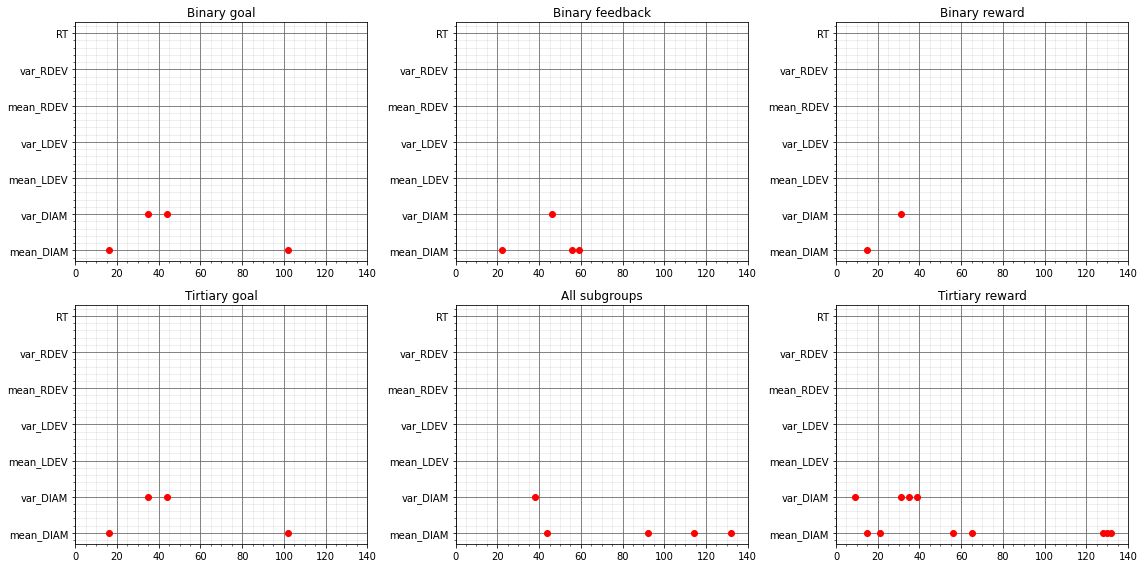

In [167]:
#Plotting the features showed
label_list = ['Binary goal','Binary feedback', 'Binary reward', 'Tirtiary goal',  'Tirtiary reward' , 'All subgroups', ]
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 140)
#custom_ylim = ('mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'RT')
     

# Setting the values for all axes.
plt.setp(axs, xlim=custom_xlim)  #, ylim=custom_ylim)

for i in range(6):
    b= dictionary_list[i]
    x, y=zip(*((int(x), k) for k in b for x in b[k]))
    if i <= 2:
        axs[0, i].plot(x, y, 'ro')
        axs[0, i].set_title(label_list[i]) 
        
    elif i ==3:
        axs[1, i-3].plot(x, y, 'ro')
        axs[1, i-3].set_title(label_list[i])
    elif i ==5:
        axs[1, 1].plot(x, y, 'ro')
        axs[1, 1].set_title(label_list[i])
        
    else:
        axs[1, 2].plot(x, y, 'ro')
        axs[1, 2].set_title(label_list[i])
        
for row in axs: 
    for ax in row: 
        ax.grid(b=True, which='major', color='#666666', linestyle='-')
        ax.minorticks_on()  
        ax.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)  
        

fig.tight_layout() 

plt.savefig('features for classification problem_5block.pdf')

In [ ]:
#scratch

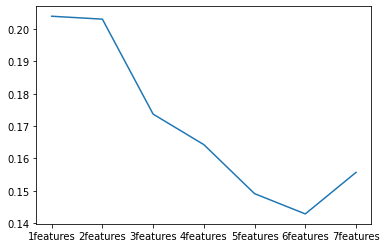

In [47]:
import matplotlib.pylab as plt

lists = sorted(number_dict_list1[5].items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [27]:
number_dict_list = np.load("number_dict_list.npy", fix_imports= True , allow_pickle= True)

In [41]:
number_dict_list[1]

{'1features': 0.5597870597870598,
 '2features': 0.61998361998362,
 '3features': 0.6961506961506961,
 '4features': 0.6457821457821458,
 '5features': 0.6474201474201474,
 '6features': 0.6998361998361999,
 '7features': 0.6728091728091729,
 '8features': 0.5716625716625716,
 '9features': 0.6273546273546273,
 '10features': 0.5835380835380835,
 '11features': 0.5966420966420967,
 '12features': 0.5954135954135954,
 '13features': 0.597051597051597,
 '14features': 0.597051597051597,
 '15features': 0.7014742014742015,
 '16features': 0.6592956592956594,
 '17features': 0.617117117117117,
 '18features': 0.617117117117117,
 '19features': 0.6408681408681409,
 '20features': 0.628992628992629,
 '21features': 0.6138411138411138,
 '22features': 0.6322686322686323,
 '23features': 0.6257166257166258,
 '24features': 0.5900900900900901,
 '25features': 0.6355446355446355,
 '26features': 0.6425061425061425,
 '27features': 0.6511056511056511,
 '28features': 0.6494676494676495,
 '29features': 0.6273546273546273,
 

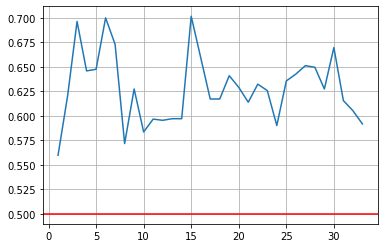

In [40]:
import matplotlib.pylab as plt
#x = [2,4,8,16,34,64,128]
x = range(1, 34)
y = number_dict_list[1].values()
plt.plot(x, y)
plt.axhline(y=0.5,  color='red')
plt.grid()
plt.show()


In [ ]:
def plot_ic_criterion(model, name, color):
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure(figsize= (10, 6))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
#plt.title('Information-criterion for model selection (training time %.3fs)'
          #% t_bic)
#figure.tight_layout() 
plt.savefig('aic bic for bi_goal.pdf')

In [64]:
best_features_methods

[(0.6870629370629371, 4, 'NuSVC'),
 (0.7666666666666666, 4, 'NuSVC'),
 (0.6642156862745098, 2, 'LinearDiscriminantAnalysis'),
 (0.4803921568627451, 14, 'KNeighborsClassifier'),
 (0.5833333333333333, 11, 'LGBMClassifier'),
 (0.20357441222102876, 5, 'XGBClassifier')]

In [48]:
#lasso_elasti_features[0]

In [154]:
df = Feature_matrix_with_labels

#getting the correct features (c4, c5, c6)
import itertools
features_for_problem = []
for i in range(1):
    no_of_features = best_features_methods[5][1] #we need features of 3,4,5 indices
    features_for_problem.append(lasso_elasti_features[5][0:no_of_features])

In [52]:
lasso_elasti_features[0][0:no_of_features]

[872, 381, 885, 486, 920, 930, 41, 942, 163, 230, 216]

In [ ]:
features_for_problem = []
features_for_problem = frequent_feature_list[5][0:8]

In [155]:
    
#Glue all the features together
features_for_problem  = list(itertools.chain(*features_for_problem) )

In [156]:
len(features_for_problem)

5

In [157]:
feature_index_list = [x-1 for x in features_for_problem] #we have to subtract 1 to get the right column feature 1 = column 0 and so on

label_series = Feature_matrix_with_labels['label_7']  
problem_df = df.iloc[:,feature_index_list]
problem_df1 = pd.concat([problem_df, label_series], axis =1) 
problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
X = problem_df2.drop('label_7', axis =1)#get the features with the right samples
X= X.astype('float')
Y = problem_df2['label_7']
Y= Y.astype('int')

clf = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
cv_results = cross_validate(clf, X, Y, cv = cv, return_estimator=True, scoring= 'balanced_accuracy')
balanced_accuracy = cv_results['test_score'].mean()


[15:33:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:33:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:33:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:33:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [158]:
balanced_accuracy

0.16488095238095235

In [145]:
feature_index_list

[70,
 177,
 15,
 118,
 185,
 174,
 191,
 23,
 69,
 52,
 183,
 98,
 168,
 101,
 170,
 131,
 55,
 178,
 174,
 14,
 64,
 129,
 20,
 127,
 148,
 177,
 43,
 131,
 113,
 91]

In [ ]:
#features_for_problem1 = freq_features[1][0:11]

In [ ]:
#inconsistency check

df = Feature_matrix_with_labels 
#features_for_problem = frequent_feature_list[0][0:15] #get the correct features
feature_index_list = [x-1 for x in features_for_problem1] #we have to subtract 1 to get the right column feature 1 = column 0 and so on
label_series = Feature_matrix_with_labels['label_7']  

problem_df = df.iloc[:,feature_index_list]
problem_df1 = pd.concat([problem_df, label_series], axis =1) 
problem_df2 = problem_df1.dropna() #This is the correct df for the problem with the right subjects
X = problem_df2.drop('label_7', axis =1)#get the features with the right samples
X= X.astype('float')
Y = problem_df2['label_7']
Y= Y.astype('int')

In [ ]:
#Getting a mean balanced score for baseline before parameter tuning

#clf = NuSVC()
clf = CalibratedClassifierCV()
#clf = GaussianNB()
#clf = SVC()
#clf = LogisticRegression()
#clf = RidgeClassifierCV()
#clf = LGBMClassifier()
#clf = LinearDiscriminantAnalysis()
#clf = NearestCentroid()
#clf = QuadraticDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
cv_results['test_score'].mean()

In [ ]:
clf = NearestCentroid(metric= 'manhattan', shrink_threshold= 0)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=1)
cv_results = cross_validate(clf, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy')
cv_results['test_score'].mean()

In [84]:
standardized_df.describe()

subject    trial right_pupil              LDEV              RDEV  \
                               mean      var     mean      var     mean   
count 48860.00 48860.00    48860.00 48860.00 48860.00 48860.00 48860.00   
mean   1049.13    70.50        0.42     0.18     0.27     0.10     0.26   
std     120.46    40.41        0.20     0.17     0.20     0.16     0.20   
min     845.00     1.00        0.00     0.00     0.00     0.00     0.00   
25%     933.00    35.75        0.27     0.06     0.11     0.01     0.11   
50%    1062.00    70.50        0.40     0.13     0.21     0.04     0.20   
75%    1153.00   105.25        0.54     0.24     0.37     0.12     0.36   
max    1246.00   140.00        1.00     1.00     1.00     1.00     1.00   

                     rt  
           var     mean  
count 48860.00 48860.00  
mean      0.12     0.26  
std       0.18     0.20  
min       0.00     0.00  
25%       0.01     0.11  
50%       0.05     0.20  
75%       0.16     0.35  
max       1.00     1.00

In [4]:
import math
math.ceil(6 / 5)

2